# CAFE Set Revisited

In 2016, I did a proof-of-concept paper for the purpose of introducing simple machine learning concepts to researchers studying developmental cognition. The point of the paper was to demonstrate how relatively low-lift statistical models could provide an enormous jump in the sensitivity of traditional psychometrics. The target of that article was differences in emotional facial expressions, specifically in young children. Researchers in the field of developmental psychology could use a facial classification system to dramatically reduce labor time required to manually labels faces in related studies. This task was selected of a proof of concept for colegues to look towards novel computational solutions when conducting laboratory research.

In that article, we trained an SVM classifier to discriminate between faces using the [Child Affective Facial Expressions (CAFE) set](https://www.childstudycenter-rutgers.com/the-child-affective-facial-expression-se). The model achieved overall accuracy of 62%. This may seem underwhelming to the ML community, but nearly matched the accuracy of human raters in discriminating between these very same stimuli (63%). The entire article can be viewed [here](https://cogsci.mindmodeling.org/2017/papers/0308/paper0308.pdf).

I've worked as an ML researcher in the six years since the article was released, and after attending a seminar on transfer learning in convolutional neural networks (CNNs)for drone operation, I was curious whether a more robust model could achieve better performance using the same data. As a first experiment, I trained a CNN on the CAFE set using standard normalizing coefficients and relatively shallow layers. In a second experiment, I took the [VGG16 CNN architecture](https://neurohive.io/en/popular-networks/vgg16/) and retrain the classifier for the purpose of discriminating emotional expressions. 

## General Imports

In [43]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split

from PIL import Image


# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Transforms

In [73]:
train_transform = transforms.Compose([
        transforms.RandomRotation(15),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485], # generic standardization scheme (means & stds)
                             [0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485],
                             [0.225])
    ])

# Experiment 1. Training a CNN From Scratch

## Datasets

The datasets are organized by participant rather than by emotional category. We have to perform some filename magic to sort files into test-train splits. 

The CAFE set aggregates nearly 1200 photos of children whose parents have voluntarally concented for use in public research. Access to the CAFE set requires approval from the dataset administrators, and will not be provided with this demonstration. 

In [12]:
# identify all files in the training dataset
source_files = glob.glob('../training_sets/CAFE_Scaled_LooseCrit/*/*')
# identify each source participant
cafeparticipants = np.unique([img.split('_')[-1].split('.jpg')[0] for img in source_files])

# double check that we're grabbing within a single participant
currentP = cafeparticipants[0]
glob.glob('../training_sets/CAFE_Scaled_LooseCrit/*/*' + "%s.jpg" %currentP)

['../training_sets/CAFE_Scaled_LooseCrit/6280/10857-neutralopen_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10098-angryopen_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10182-disgust_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/9977-angry_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/11020-sadopen_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10373-fearful_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10728-neutral_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10278-disgustwithtongue_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10633-happyopen_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/11066-surprise_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10513-happy_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10452-fearfulopen_F-AA-01.jpg',
 '../training_sets/CAFE_Scaled_LooseCrit/6280/10958-sad_F-AA-01.jpg']

In [47]:
all_data = datasets.ImageFolder('../training_sets/CAFE_Scaled_LooseCrit/')

In [130]:
# get all files, participants and labels
source_files = glob.glob('../training_sets/CAFE_Scaled_LooseCrit/*/*')
cafeparticipants = [img.split('_')[-1].split('.jpg')[0] for img in source_files]
labels = [e for s in source_files for e in emotions if e in s]

# identify class names and convert to numeric labels
class_names = np.unique(labels)
class_names.sort()
class_dict = dict(zip(class_names, range(len(class_names))))
label_to_class = {v: k for k, v in class_dict.items()}
labels = [class_dict[l] for l in labels]

# split source files into test and train splits
# in the original article, we split participants into test and train splits
# but here I'd prefer to have proportional sampling by labels
# it's an empirical question how much this decision alone might impart classifier generalization
print(len(source_files), len(cafeparticipants), len(labels))
train_files, test_files, train_labels, test_labels = train_test_split(source_files, labels , test_size=.2, shuffle=True, stratify=labels)

1187 1187 1187


### Resampling

Given the small dataset we're operating within, all training data will be resampled five times, under conditions of random rotation and horizontal flipping. The test data is only transformed to be a compatable image size.

In [246]:
resample_rate = 5 #let's resample several times with rotations and translations
train_data = []
for r in range(resample_rate):
    for f, l in zip(train_files, train_labels):
        im = Image.open(f)
        train_data.append((train_transform(im), l))

test_data = []
for f, l in zip(test_files, test_labels):
    im = Image.open(f)
    test_data.append((test_transform(im), l))        
    
train_n = len(train_data)
test_n = len(test_data)

In [247]:
train_n, test_n

(4745, 238)

In [248]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: tensor([4, 3, 4, 4, 1])
Class: ['neutral', 'happy', 'neutral', 'neutral', 'disgust']
Label: tensor([3, 0, 2, 1, 4])
Class: ['happy', 'angry', 'fearful', 'disgust', 'neutral']


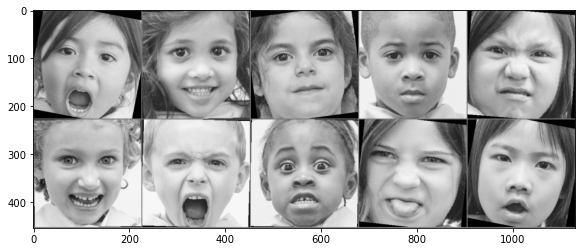

In [252]:
# visualizing a batch to confirm rotation and flipping

#toggle comment to check test vs train data
# for images, label in test_loader:
for images, label in train_loader:
    break
    
im = make_grid(images, nrow=5)  # the default nrow is 8

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.225],
    std=[1/0.225]
)

im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));
print('Label:', label[0:5])
print('Class:', [label_to_class[l] for l in label.numpy()[0:5]])
print('Label:', label[5:])
print('Class:', [label_to_class[l] for l in label.numpy()[5:]])


## Define the Model

Here, I'm using a simple structure with two convluational layers punctuated by max pooling layers, which feed into three fully connected layers. For loss function, I'm sticking with the unfussing cross entropy loss, and an Adam optimizer with a learning rate of 0.1%.

In [254]:
class CNN(nn.Module):
    """
    Convolutional Neural Network class. Layers and parameters are set
    explicitly for 224x224 pixel images. 
    """
    
    def __init__(self, n_classes=7):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [255]:
torch.manual_seed(8675309)
CNNmodel = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=7, bias=True)
)

## Train the Model

Despire the moderately large number of parameters, this model can be trained on CPU alone due to the small dataset. Increasing the dataset will require using GPU servers.

In [256]:
import time
start_time = time.time()

epochs = 5

train_losses = []
test_losses = []
train_correct = []
test_correct = []

train_n = len(train_loader.dataset)
test_n = len(test_loader.dataset)

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{train_n}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   10 [   100/4745]  loss: 1.78965664  accuracy:  19.000%
epoch:  0  batch:   20 [   200/4745]  loss: 1.94721949  accuracy:  15.000%
epoch:  0  batch:   30 [   300/4745]  loss: 1.81427228  accuracy:  17.333%
epoch:  0  batch:   40 [   400/4745]  loss: 2.09648776  accuracy:  18.250%
epoch:  0  batch:   50 [   500/4745]  loss: 1.87225688  accuracy:  21.200%
epoch:  0  batch:   60 [   600/4745]  loss: 2.12610960  accuracy:  21.167%
epoch:  0  batch:   70 [   700/4745]  loss: 1.96414626  accuracy:  22.571%
epoch:  0  batch:   80 [   800/4745]  loss: 1.89124453  accuracy:  23.625%
epoch:  0  batch:   90 [   900/4745]  loss: 1.76595652  accuracy:  24.000%
epoch:  0  batch:  100 [  1000/4745]  loss: 1.62097514  accuracy:  25.300%
epoch:  0  batch:  110 [  1100/4745]  loss: 1.78689671  accuracy:  25.273%
epoch:  0  batch:  120 [  1200/4745]  loss: 1.62979925  accuracy:  26.083%
epoch:  0  batch:  130 [  1300/4745]  loss: 1.48179364  accuracy:  26.769%
epoch:  0  batch:  140 [ 

epoch:  2  batch:  170 [  1700/4745]  loss: 0.42582798  accuracy:  85.647%
epoch:  2  batch:  180 [  1800/4745]  loss: 0.23545206  accuracy:  85.889%
epoch:  2  batch:  190 [  1900/4745]  loss: 0.15668356  accuracy:  85.842%
epoch:  2  batch:  200 [  2000/4745]  loss: 0.13779557  accuracy:  86.000%
epoch:  2  batch:  210 [  2100/4745]  loss: 0.54549134  accuracy:  86.190%
epoch:  2  batch:  220 [  2200/4745]  loss: 0.32624230  accuracy:  86.227%
epoch:  2  batch:  230 [  2300/4745]  loss: 0.38975951  accuracy:  85.913%
epoch:  2  batch:  240 [  2400/4745]  loss: 0.11247325  accuracy:  86.208%
epoch:  2  batch:  250 [  2500/4745]  loss: 0.32201710  accuracy:  86.360%
epoch:  2  batch:  260 [  2600/4745]  loss: 0.70876062  accuracy:  86.269%
epoch:  2  batch:  270 [  2700/4745]  loss: 1.07630646  accuracy:  86.333%
epoch:  2  batch:  280 [  2800/4745]  loss: 0.11486492  accuracy:  86.536%
epoch:  2  batch:  290 [  2900/4745]  loss: 0.03919443  accuracy:  86.621%
epoch:  2  batch:  300 [ 

epoch:  4  batch:  330 [  3300/4745]  loss: 0.03617905  accuracy:  97.970%
epoch:  4  batch:  340 [  3400/4745]  loss: 0.60435617  accuracy:  97.912%
epoch:  4  batch:  350 [  3500/4745]  loss: 0.00394685  accuracy:  97.857%
epoch:  4  batch:  360 [  3600/4745]  loss: 0.06629209  accuracy:  97.833%
epoch:  4  batch:  370 [  3700/4745]  loss: 0.22093251  accuracy:  97.838%
epoch:  4  batch:  380 [  3800/4745]  loss: 0.27343774  accuracy:  97.737%
epoch:  4  batch:  390 [  3900/4745]  loss: 0.18563199  accuracy:  97.692%
epoch:  4  batch:  400 [  4000/4745]  loss: 0.01665034  accuracy:  97.700%
epoch:  4  batch:  410 [  4100/4745]  loss: 0.10824133  accuracy:  97.659%
epoch:  4  batch:  420 [  4200/4745]  loss: 0.02402237  accuracy:  97.690%
epoch:  4  batch:  430 [  4300/4745]  loss: 0.25346643  accuracy:  97.674%
epoch:  4  batch:  440 [  4400/4745]  loss: 0.16827872  accuracy:  97.636%
epoch:  4  batch:  450 [  4500/4745]  loss: 0.34984472  accuracy:  97.578%
epoch:  4  batch:  460 [ 

In [257]:
torch.save(CNNmodel.state_dict(), 'CAFE_CNNModel-5_rep_b.pt')

## Experiment 1: Results

We see a strong within-set training rate. This is expected, given the resampling among the training data. Looking at the validation set shows much more modest gains, with increasing validation loss per epoch as is typical of resampling techniques. However, the overall accuracy rate is still higher than expected from chance **and** human raters, a full 5% better performance than the initial demonstration in 2016. 

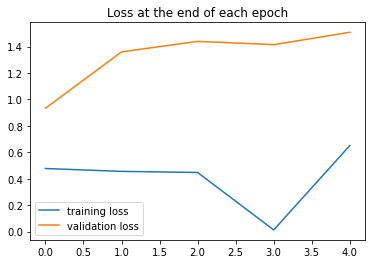

In [258]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

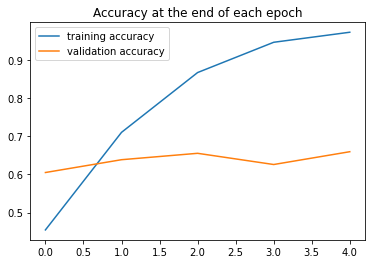

In [259]:
plt.plot([t.numpy()/train_n for t in train_correct], label='training accuracy')
plt.plot([t.numpy()/test_n for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [261]:
print(f'Final validation accuracy: {(test_correct[-1].numpy() / test_n)*100:3.3f}%')
print(f'\t chance at {1/len(class_names)*100:3.3f}%)')
print('\t human performance at 63%)')

Final validation accuracy: 65.966%
	 chance at 14.286%)
	 human performance at 63%)


# Experiment 2: Using pre-trained models for emotional categorization

The [VGG16 model](https://neurohive.io/en/popular-networks/vgg16/) is a state of the art CNN that has found success in a wide number of image classification tasks. It was trained using a hardware cluster of epic proportions. By retraining the model's classifier, we can repurpose that hard-earned training for the slightly different task of distinguishin between faces (as opposed to the original operation, which would be to identify whether the image was a face vs some other image class).

In [217]:
from torchvision import models
VGGmodel = models.vgg16(pretrained=True)
VGGmodel

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/lewisbaker/.cache/torch/checkpoints/vgg16-397923af.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [220]:
# freeze existing parameters
for param in VGGmodel.parameters():
    param.requires_grad = False

# set a new classifier
torch.manual_seed(222)
VGGmodel.classifier = nn.Sequential(nn.Linear(25088, 9216),
                                    nn.ReLU(),
                                    nn.Dropout(0.4),
                                    nn.Linear(9216, 1024),
                                    nn.ReLU(),
                                    nn.Dropout(0.4),
                                    nn.Linear(1024, len(class_names)),
                                    nn.LogSoftmax(dim=1))
VGGmodel

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [221]:
# These are the TRAINABLE parameters:
# Man, I'm going to be here all day
# Update: yes, I was
count_parameters(VGGmodel)

231211008
    9216
 9437184
    1024
    7168
       7
________
240665607


### A brief note on grayscale images

The files used for the homebrew CNN were already greyscaled. The VGG network anticipates three channels (RGB). There are a few ways to deal with this. First, we could change this input channels of the VGG network; however, this is strongly not advised, as all trained parameters would demonstrate incredible downstream bias. Second, we could grab the original color photographs and re-preprocess. Admittedly, this would be the more rigorous solution, but I promised myself I'd do this in an afternoon for a brownbag at the end of the week, and I've got to cut corners somehow. The third option is to propogate each image's grayscale channel to three redundant channels for input. This surprisingly does not violate the pretrained networks as much as I had initially assumed, and is a reasonable cheat. Obviously this is done for demonstration purposes alone, and any production use of the model should go with the highest quality solution possible.

In [269]:
# numpy.repeat allows all axes to be repeated along a given access
# perfect for what we need here
for X in X_train:
    print(X_train.shape)
    print(np.repeat(X_train, 3, 1).shape)
    print(X.shape, np.repeat(X, 3, 0).shape)
    break

torch.Size([5, 1, 224, 224])
torch.Size([5, 3, 224, 224])
torch.Size([1, 224, 224]) torch.Size([3, 224, 224])


## Define Loss & Optimizer

In [223]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGGmodel.classifier.parameters(), lr=0.001)

In [245]:
import time
start_time = time.time()

epochs = 3 #already ran once before, so this will technically make 4 total epochs

train_losses = []
test_losses = []
train_correct = []
test_correct = []

train_n = len(train_loader.dataset)
test_n = len(test_loader.dataset)

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        ## NOTE: have to reshape X to simulate RGB values
        X_train = np.repeat(X_train, 3, 1)
        
        b+=1
        
        # Apply the model
        y_pred = VGGmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{train_n}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            X_test = np.repeat(X_test, 3, 1)

            # Apply the model
            y_val = VGGmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   10 [   100/4745]  loss: 0.84217280  accuracy:  65.000%
epoch:  0  batch:   20 [   200/4745]  loss: 1.39512062  accuracy:  71.500%
epoch:  0  batch:   30 [   300/4745]  loss: 0.64481455  accuracy:  67.667%
epoch:  0  batch:   40 [   400/4745]  loss: 0.27830535  accuracy:  68.750%
epoch:  0  batch:   50 [   500/4745]  loss: 1.50604761  accuracy:  66.400%
epoch:  0  batch:   60 [   600/4745]  loss: 0.99434614  accuracy:  66.167%
epoch:  0  batch:   70 [   700/4745]  loss: 0.42466801  accuracy:  66.143%
epoch:  0  batch:   80 [   800/4745]  loss: 1.04513347  accuracy:  66.000%
epoch:  0  batch:   90 [   900/4745]  loss: 1.02280498  accuracy:  66.667%
epoch:  0  batch:  100 [  1000/4745]  loss: 0.86209023  accuracy:  67.100%
epoch:  0  batch:  110 [  1100/4745]  loss: 0.75916338  accuracy:  67.182%
epoch:  0  batch:  120 [  1200/4745]  loss: 0.40271395  accuracy:  67.917%
epoch:  0  batch:  130 [  1300/4745]  loss: 0.60279542  accuracy:  68.308%
epoch:  0  batch:  140 [ 

epoch:  2  batch:  170 [  1700/4745]  loss: 1.21031332  accuracy:  82.294%
epoch:  2  batch:  180 [  1800/4745]  loss: 0.53283823  accuracy:  82.611%
epoch:  2  batch:  190 [  1900/4745]  loss: 0.12417539  accuracy:  82.895%
epoch:  2  batch:  200 [  2000/4745]  loss: 0.08555003  accuracy:  83.100%
epoch:  2  batch:  210 [  2100/4745]  loss: 0.56589931  accuracy:  83.000%
epoch:  2  batch:  220 [  2200/4745]  loss: 1.18241405  accuracy:  82.864%
epoch:  2  batch:  230 [  2300/4745]  loss: 0.37332734  accuracy:  82.652%
epoch:  2  batch:  240 [  2400/4745]  loss: 0.90926611  accuracy:  82.833%
epoch:  2  batch:  250 [  2500/4745]  loss: 1.33626676  accuracy:  82.720%
epoch:  2  batch:  260 [  2600/4745]  loss: 1.59287298  accuracy:  82.615%
epoch:  2  batch:  270 [  2700/4745]  loss: 0.61584151  accuracy:  82.630%
epoch:  2  batch:  280 [  2800/4745]  loss: 1.38520873  accuracy:  82.571%
epoch:  2  batch:  290 [  2900/4745]  loss: 0.03859160  accuracy:  82.655%
epoch:  2  batch:  300 [ 

## Experiment 2: Results

I'm a little surprised that the retrained VGG model produced such mediocre results. I wasn't expecting it to be better than a natively trained CNN, but I thought it would still do better than a kernel SVM from the original paper

In [272]:
print(f'Final validation accuracy: {(test_correct[-1].numpy() / test_n)*100:3.3f}% (chance at {1/len(class_names)*100:3.3f}%)')

Final validation accuracy: 50.478% (chance at 14.286%)


In [273]:
torch.save(VGGmodel.state_dict(), 'CAFE_VGG19-5_rep.pt')